# An example using Feature weighted ECM clustering


In [1]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Toys DS: 400 instances, 6 features


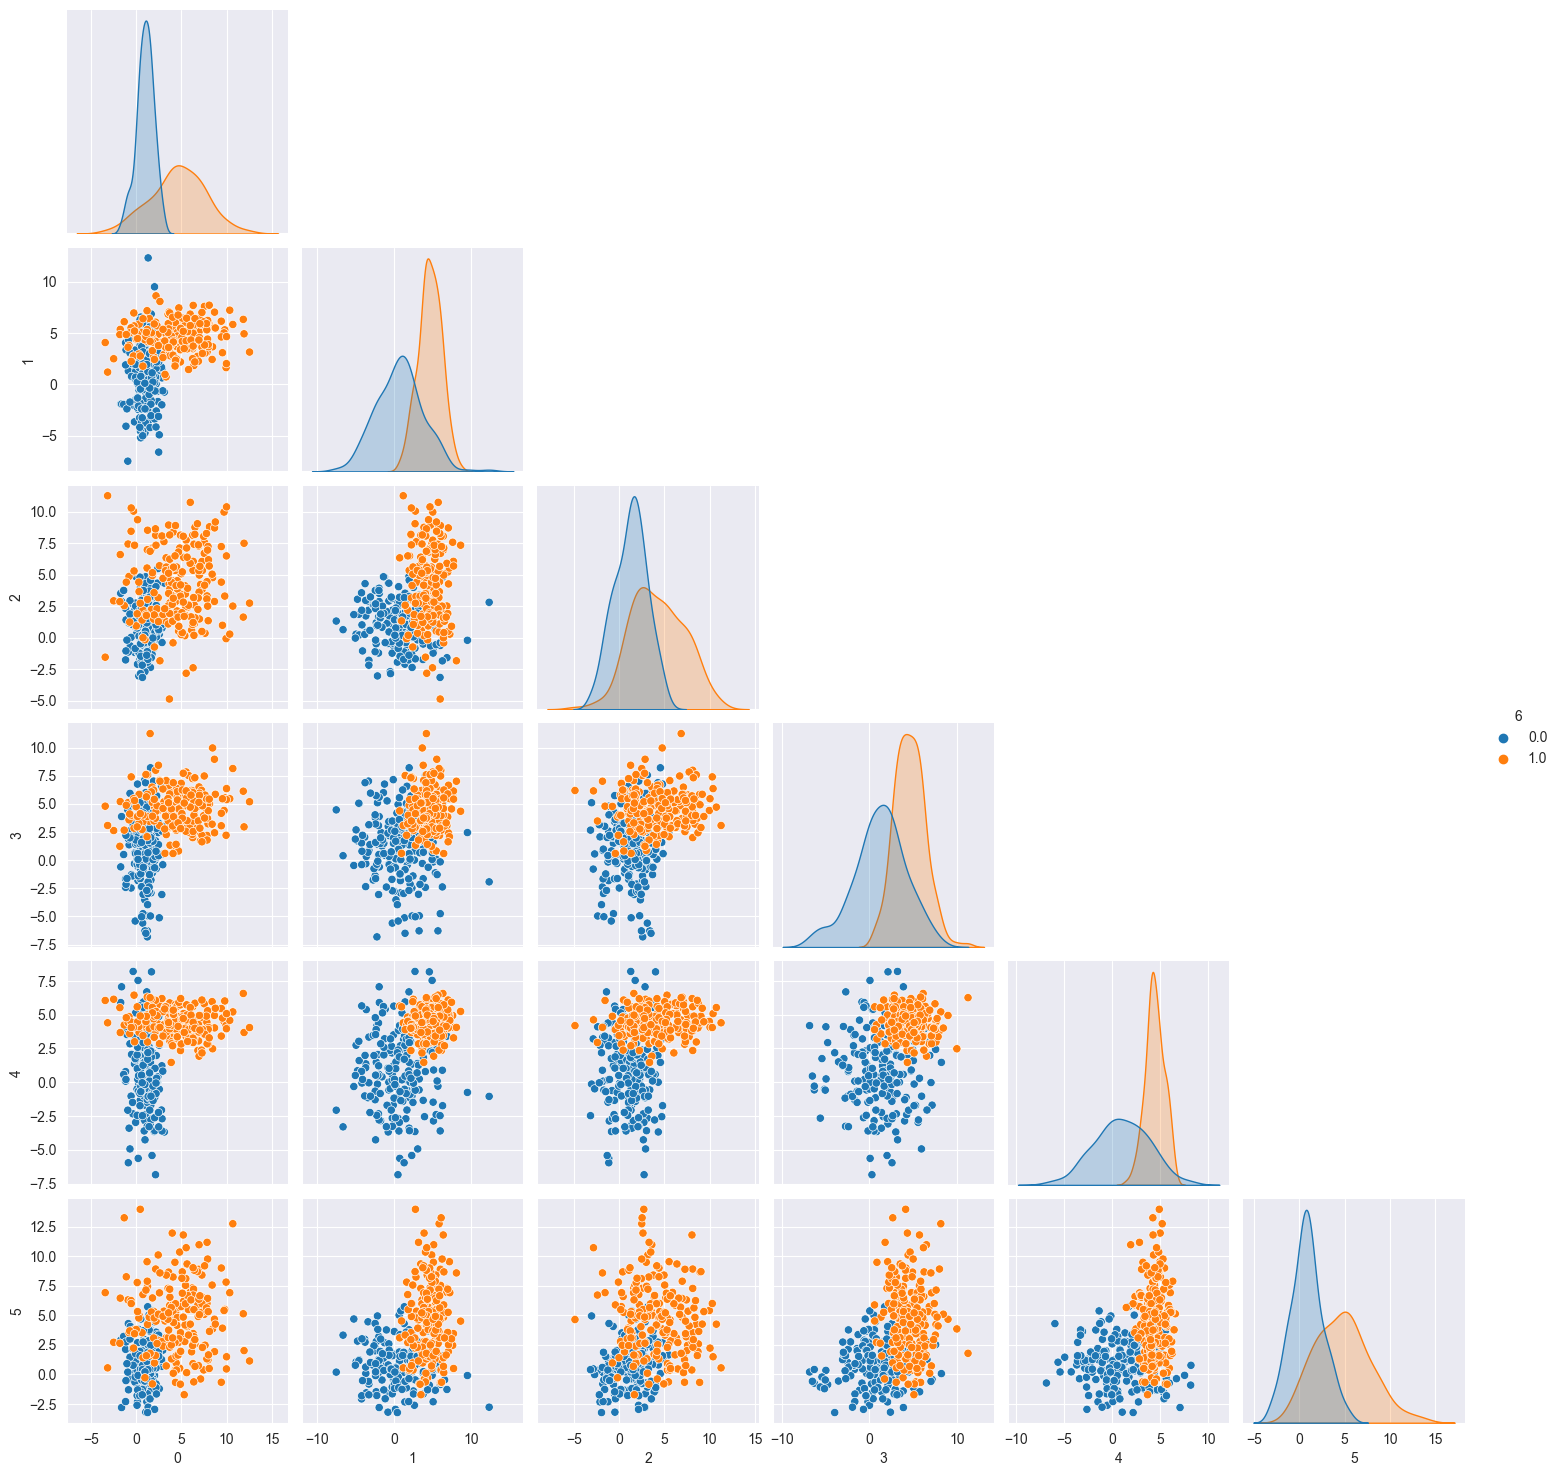

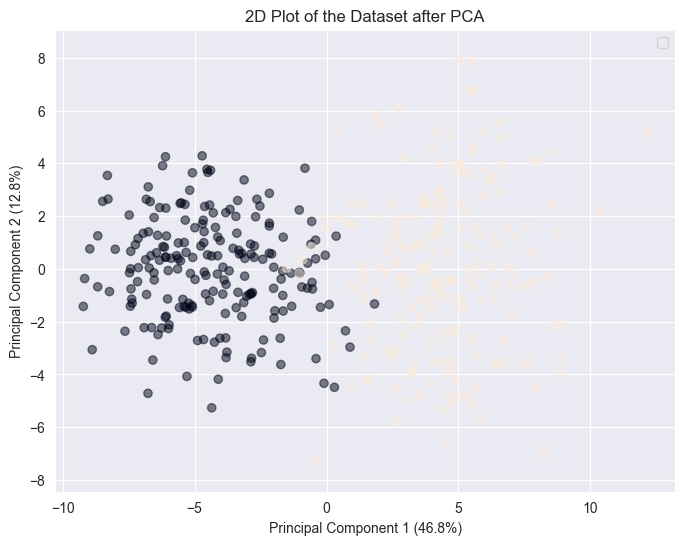

In [2]:
## Generating data set
# Number of points in each cluster
num_points = 200

# Number of dimensions for each point
num_dimensions = 6

# Mean and covariance matrices for each cluster
identity = np.eye(6)
cov_matrix1 = np.array([1, 8, 3, 7, 9, 4]).reshape((6, 1)) * identity
cov_matrix2 = np.array([9, 2, 10, 3, 1, 8]).reshape((6, 1)) * identity

cluster_params = [
    {"mean": [1, 1, 1, 1, 1, 1], "covariance": cov_matrix1, "label": 0},
    {"mean": [4.5, 4.5, 4.5, 4.5, 4.5, 4.5], "covariance": cov_matrix2, "label": 1},
]

# Generate data for each cluster
# data = np.concatenate([np.random.multivariate_normal(params["mean"], params["covariance"], num_points) for params in cluster_params])
dataset = np.concatenate(
    [np.column_stack((np.random.multivariate_normal(params["mean"], params["covariance"], num_points),
                      np.full((num_points, 1), params["label"]))) for params in cluster_params])
df = pd.DataFrame(data=dataset[:, :-1])

# Scatter matrix plot
df_wt_label = pd.DataFrame(dataset)
sns.pairplot(df_wt_label, corner=True, hue=df_wt_label.columns[-1])

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions
data_reduced = pca.fit_transform(dataset[:, :-1])
variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

print(f"Toys DS: {df.shape[0]} instances, {df.shape[1]} features")
# Plot the reduced dataset with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], alpha=0.5, c=dataset[:, -1])
plt.title('2D Plot of the Dataset after PCA')
plt.xlabel(f"Principal Component 1 ({variance_percent[0]}%)")
plt.ylabel(f"Principal Component 2 ({variance_percent[1]}%)")
plt.legend()
plt.grid(True)
plt.axis('equal')
# plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [4]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")
    # Plot the values
    # plt.clf()
    # plt.hist(object_non_specificity, bins=30, density=True, alpha=0.7, color='blue')
    # plt.xlabel('Value')
    # plt.ylabel('Density')
    # plt.title('Non-specificity Value Distribution Plot')
    # plt.grid(True)
    # plt.show()

## Traditional ECM

[1, 7580.119247580499]
[2, 7573.114237754258]
[3, 7572.636643358845]
[4, 7572.5764975222]
[5, 7572.5677494009515]
[6, 7572.56621897429]
[7, 7572.565876094255]
[   0.         7572.56587609 7572.56587609]
[1, 7580.119247580499]
[2, 7573.114237754258]
[3, 7572.636643358845]
[4, 7572.5764975222]
[5, 7572.5677494009515]
[6, 7572.56621897429]
[7, 7572.565876094255]
[1.00000000e+00 7.57256588e+03 7.57256588e+03]
[1, 7580.119247580499]
[2, 7573.114237754258]
[3, 7572.636643358845]
[4, 7572.5764975222]
[5, 7572.5677494009515]
[6, 7572.56621897429]
[7, 7572.565876094255]
[2.00000000e+00 7.57256588e+03 7.57256588e+03]
[1, 7580.119247580499]
[2, 7573.114237754258]
[3, 7572.636643358845]
[4, 7572.5764975222]
[5, 7572.5677494009515]
[6, 7572.56621897429]
[7, 7572.565876094255]
[3.00000000e+00 7.57256588e+03 7.57256588e+03]
[1, 7580.119247580499]
[2, 7573.114237754258]
[3, 7572.636643358845]
[4, 7572.576497522201]
[5, 7572.5677494009515]
[6, 7572.56621897429]
[7, 7572.565876094255]
[4.00000000e+00 7.

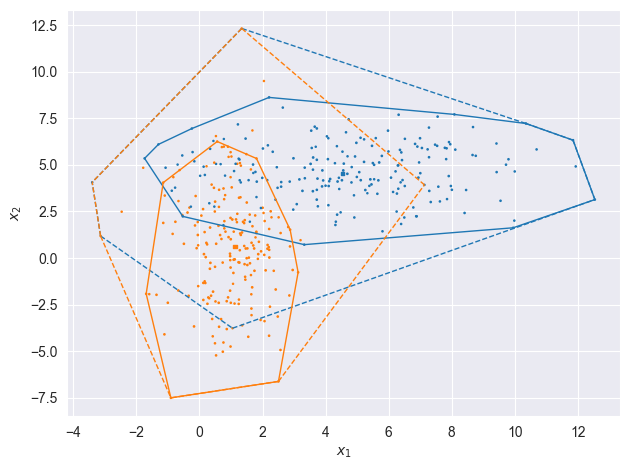

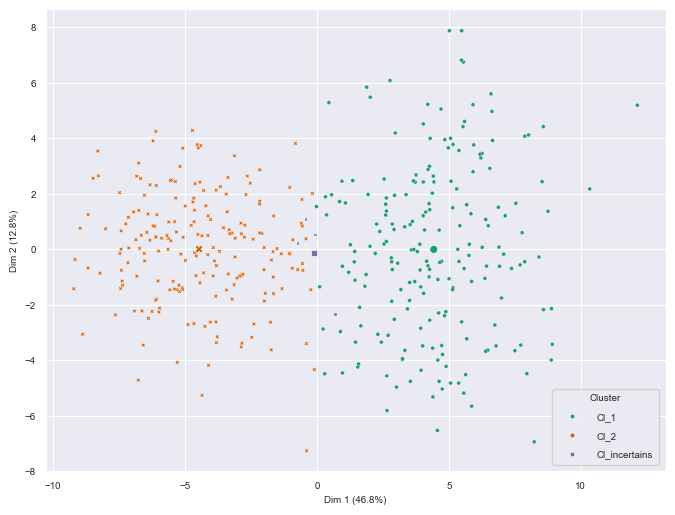

----------Traditional ECM----------
Adjusted Rand Index (ARI): 0.8739089903323498
Maximum Non-specificity value: 1.664362591962754
Minimum Non-specificity value: 0.11740511158023521
Average Non-specificity value: 0.9754322166806386


In [7]:
# Traditional ECM clustering
model = ecm(x=df, c=2, beta=2, alpha=1, delta=100, ntrials=5)

ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = dataset[:, -1].astype(int)
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Traditional ECM----------")
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Feature weighted ECM (FW-ECM)

[1, 215.09824612534536]
[2, 166.57365035939708]
[3, 144.36715115823796]
[4, 136.48995532166862]
[5, 134.2556342079997]
[6, 133.59510338524785]
[7, 133.37079379278265]
[8, 133.28459294399963]
[9, 133.24874729550973]
[10, 133.23332389600301]
[11, 133.22611619044488]
[12, 133.2229003806193]
[13, 133.2219717134903]
[  0.         133.22197171 133.22197171]
[1, 224.929060777186]
[2, 174.36720956024314]
[3, 145.25121081148518]
[4, 136.4242930951352]
[5, 134.23838466480188]
[6, 133.5941990048679]
[7, 133.3724660970531]
[8, 133.2863821393123]
[9, 133.2501832061759]
[10, 133.23439916838018]
[11, 133.22692036251604]
[12, 133.22353568004218]
[13, 133.22254015053767]
[  1.         133.22254015 133.22197171]
[1, 196.84018023200056]
[2, 164.30029140175216]
[3, 144.97579656367293]
[4, 136.81058568799284]
[5, 134.34995653258508]
[6, 133.62926268095902]
[7, 133.38795180069218]
[8, 133.2949029627871]
[9, 133.2554446329221]
[10, 133.2370825191647]
[11, 133.2289434275789]
[12, 133.2243330469238]
[13, 133.2

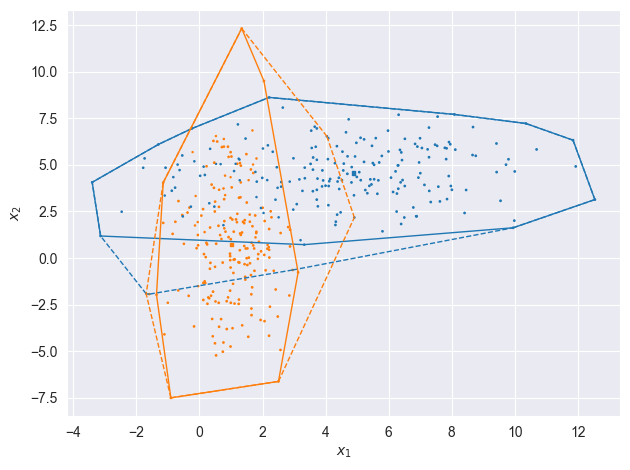

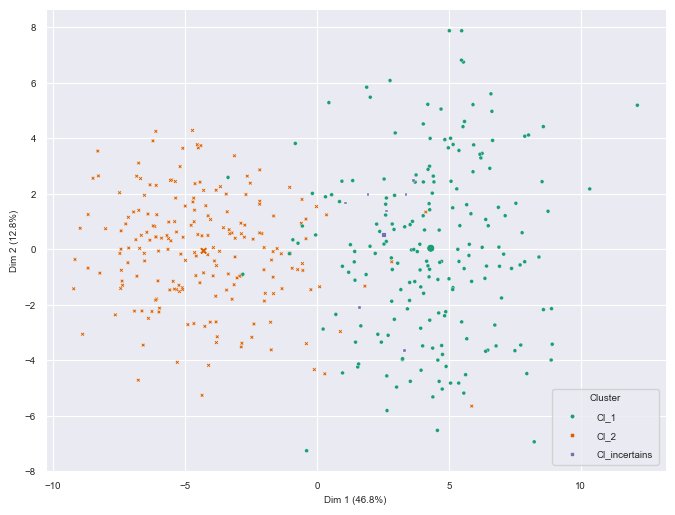

Weight matrix: 
 [[0.05134583 0.17378257 0.05764524 0.14877948 0.51827601 0.05017088]
 [0.51208073 0.05683239 0.15079417 0.05794018 0.06632298 0.15602953]]
Covariance Matrix 1: [9.33605504 2.24988283 8.61597318 3.16116196 0.89052002 9.27409615]
Covariance Matrix 2: [0.85094189 9.33876303 3.4557834  9.37133594 8.26740062 3.22326715]


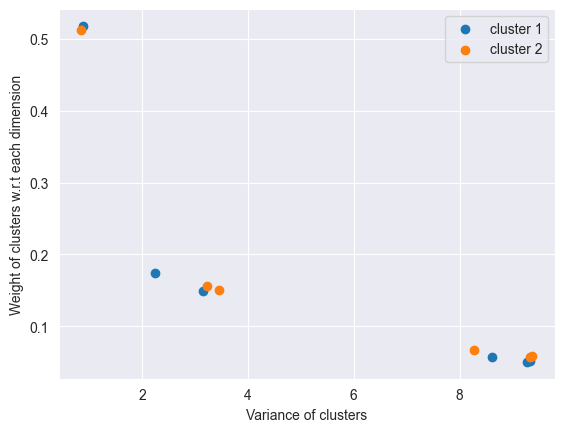

----------Feature weighted ECM----------
Adjusted Rand Index (ARI): 0.8927562253293828 - J value: 133.22134153991942
Maximum Non-specificity value: 2.1957744835477433
Minimum Non-specificity value: 0.04846901516876288
Average Non-specificity value: 0.8078211732015359


In [13]:
# Feature weighted ECM clustering
c = 2

# W = np.array([
#     [0.05646759, 0.1260448, 0.07465787, 0.12601725, 0.54139234, 0.07542015],
#     [0.4605951, 0.06080976, 0.20984217, 0.06306819, 0.05947266, 0.14621213]
# ])
model = fwecm(x=df, c=c, beta=2, alpha=1, delta=100, ntrials=5)

ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)


true_labels = dataset[:, -1].astype(int)
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

## Plot weight-variance correlation
W = model['W']
print(f"Weight matrix: \n {W}")
cov_mat1 = np.cov(df[predicted_labels == 0].transpose())
cov_mat2 = np.cov(df[predicted_labels == 1].transpose())
print(f"Covariance Matrix 1: {cov_mat1.diagonal()}")
print(f"Covariance Matrix 2: {cov_mat2.diagonal()}")

W_COV_1 = pd.DataFrame({'y': W[0, :], 'x': cov_mat1.diagonal()})
W_COV_1.sort_values('x', inplace=True)
W_COV_2 = pd.DataFrame({'y': W[1, :], 'x': cov_mat2.diagonal()})
W_COV_2.sort_values('x', inplace=True)

plt.clf()
plt.scatter(W_COV_1['x'], W_COV_1['y'], label = "cluster 1", marker='o')
plt.scatter(W_COV_2['x'], W_COV_2['y'], label = "cluster 2", marker='o')
plt.xlabel("Variance of clusters")
plt.ylabel("Weight of clusters w.r.t each dimension")
plt.legend()
plt.show()

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Feature weighted ECM----------")
print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Non-specificity equation
![test.png](assets/Non-specificity.png)